# COVID-19 Analysis

## Preliminaries

In [1]:
%matplotlib inline
# produce vector inline graphics
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tempfile
import requests
import zipfile
import datetime
from pathlib import Path
from IPython.display import display, Markdown
from functools import reduce
import humanize

In [2]:
print(f"Generated on {datetime.datetime.utcnow()} UTC")

Generated on 2021-11-22 10:01:43.708690 UTC


## Data retrieval
### Get OurWorldInData data

In [3]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
df.index = pd.to_datetime(df.date)
df["death_ratio"] = df.new_deaths_smoothed_per_million / df.new_cases_smoothed_per_million

### French data

In [4]:
fr_dep_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5")
fr_dep_df.index = pd.to_datetime(fr_dep_df.date)

fr_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617")
fr_df.index = pd.to_datetime(fr_df.date)

/home/pagessin/dev/covid19/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# fr_icu_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/eceb9fb4-3ebc-4da3-828d-f5939712600a", sep=";")
fr_icu_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7", sep=";")
fr_icu_df[fr_icu_df.dep == "01"]

,dep,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,01,0,2020-03-18,2,0,NaN,NaN,NaN,1,0
1,01,1,2020-03-18,1,0,NaN,NaN,NaN,1,0
2,01,2,2020-03-18,1,0,NaN,NaN,NaN,0,0
305,01,0,2020-03-19,2,0,NaN,NaN,NaN,1,0
306,01,1,2020-03-19,1,0,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...
186661,01,1,2021-11-20,20,1,8.0,10.0,1.0,1518,378
186662,01,2,2021-11-20,24,1,12.0,10.0,1.0,1513,263
186965,01,0,2021-11-21,47,2,23.0,20.0,2.0,3056,644
186966,01,1,2021-11-21,20,1,8.0,10.0,1.0,1518,378


### Swiss data

In [6]:
r = requests.get("https://www.covid19.admin.ch/api/data/context", timeout=10)
url = r.json()["sources"]["zip"]["csv"]
# print(url)

with tempfile.TemporaryDirectory() as d:
    dl = Path(d) / "dl.zip"
#     print(dl.resolve())
    with requests.get(url, stream=True, timeout=10) as r:
        with dl.open("wb") as fh:
            r.raise_for_status()
            for chunk in r.iter_content(chunk_size=8192): 
                fh.write(chunk)

    with zipfile.ZipFile(fh.name) as z:
        with z.open("data/COVID19Cases_geoRegion.csv") as fh:
            ch_df = pd.read_csv(fh)
            
        with z.open("data/COVID19HospCapacity_geoRegion.csv") as fh:
            ch_icu_df = pd.read_csv(fh)
            
ch_df.index = pd.to_datetime(ch_df.datum)
ch_icu_df.index = pd.to_datetime(ch_icu_df.date)

# ch_icu_df = ch_icu_df[ch_icu_df.geoRegion == "CH"]
ch_icu_df = ch_icu_df[["geoRegion", "ICU_Covid19Patients", "ICU_NonCovid19Patients", "ICU_FreeCapacity"]]
ch_icu_df.columns = ["canton", "used_covid", "used_non_covid", "free"]
ch_icu_df.index

DatetimeIndex(['2020-03-30', '2020-03-30', '2020-03-30', '2020-03-30',
               '2020-03-30', '2020-03-30', '2020-03-30', '2020-03-30',
               '2020-03-30', '2020-03-30',
               ...
               '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-13', '2021-11-14', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18'],
              dtype='datetime64[ns]', name='date', length=32346, freq=None)

### German data

In [7]:
r = requests.get("https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Fallzahlen_Inzidenz_aktualisiert.xlsx?__blob=publicationFile", timeout=10)
ger_df = pd.read_excel(r.content, engine='openpyxl', sheet_name="BL_7-Tage-Fallzahl-aktualisiert")
ger_df = ger_df.transpose()
states = list(ger_df.iloc[0][4:])
ger_df = ger_df.iloc[1:]
ger_df = ger_df.drop([0, 1, 3], axis=1)
ger_df.columns = ["date"] + states
ger_df.index = pd.to_datetime(ger_df.date)
ger_df = ger_df.drop("date", axis=1)
ger_df = ger_df.iloc[:np.argmax(ger_df.isna().all(axis=1))] # remove everything after first all-NaN row
ger_df["Germany"] = ger_df.sum(axis=1)
# ger_df
ger_inc_df = ger_df[["Germany"]].copy()
ger_inc_df.Germany *= 1/83_100_000 * 100_000
# ger_inc_df

In [8]:
ger_icu_df = pd.read_csv("https://diviexchange.blob.core.windows.net/%24web/zeitreihe-deutschland.csv")
ger_icu_df.Datum = ger_icu_df.Datum.apply(lambda s: s.split("T")[0])
ger_icu_df.Datum = pd.to_datetime(ger_icu_df.Datum)
ger_icu_df.index = ger_icu_df.Datum
ger_icu_df = ger_icu_df.drop(["Datum"], axis=1)
ger_icu_df = ger_icu_df[ger_icu_df.Bundesland == "DEUTSCHLAND"]
ger_icu_df = ger_icu_df.groupby(ger_icu_df.index).sum()

ger_icu_df["used_non_covid"] = ger_icu_df.Belegte_Intensivbetten - ger_icu_df.Aktuelle_COVID_Faelle_ITS
ger_icu_df = ger_icu_df[["Aktuelle_COVID_Faelle_ITS", "used_non_covid", "Freie_Intensivbetten"]]
ger_icu_df.columns = ["used_covid", "used_non_covid", "free"]
ger_icu_df.index

DatetimeIndex(['2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29',
               ...
               '2021-11-12', '2021-11-13', '2021-11-14', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-20', '2021-11-21'],
              dtype='datetime64[ns]', name='Datum', length=612, freq=None)

In [9]:
icu_labels = ["COVID19 ICU patients", "Other ICU patients", "Free capacity"]

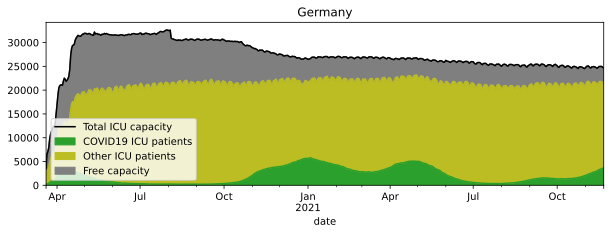

In [10]:
fig, ax = plt.subplots(figsize=(10,3))
ger_icu_df.plot.area(y=["used_covid", "used_non_covid", "free"], stacked=True, color=["tab:green", "tab:olive", "tab:grey"], label=icu_labels, ax=ax)
(ger_icu_df.used_covid+ger_icu_df.used_non_covid+ger_icu_df.free).plot(ax=ax, label="Total ICU capacity", c="black")
ax.set_title("Germany")
ax.set_xlabel("date")
ax.legend()

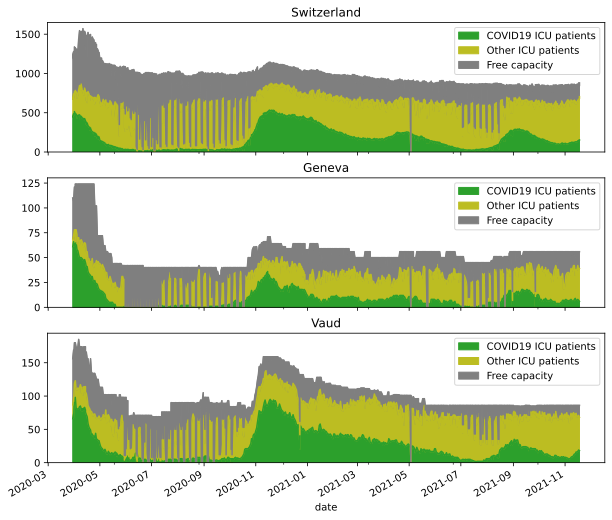

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
for ax, reg in zip(axs, ("CH", "GE", "VD")):
    reg_icu_df = ch_icu_df[ch_icu_df.canton == reg]
    reg_icu_df.plot.area(y=["used_covid", "used_non_covid", "free"], stacked=True, color=["tab:green", "tab:olive", "tab:grey"], label=icu_labels, ax=ax)
#     (reg_icu_df.used_covid+reg_icu_df.used_non_covid+reg_icu_df.free).plot(ax=ax, label="Total ICU capacity", c="black")
    ax.set_title({"CH": "Switzerland", "GE": "Geneva", "VD": "Vaud"}[reg])
    ax.set_xlabel("date")
    ax.legend()

## Incidences

In [12]:
inc_df = reduce(lambda l, r: l.join(r, how="outer"), [
    fr_dep_df[fr_dep_df.lib_dep == "Ain"][["tx_incid"]].rename(columns={"tx_incid": "Ain"}),
    fr_df[["tx_incid"]].rename(columns={"tx_incid": "France"}),
    ch_df[ch_df.geoRegion == "GE"][["inzsum7d"]].rename(columns={"inzsum7d": "Geneva"}),
    ch_df[ch_df.geoRegion == "VD"][["inzsum7d"]].rename(columns={"inzsum7d": "Vaud"}),
    ch_df[ch_df.geoRegion == "CH"][["inzsum7d"]].rename(columns={"inzsum7d": "Switzerland"}),
    ger_inc_df,
])

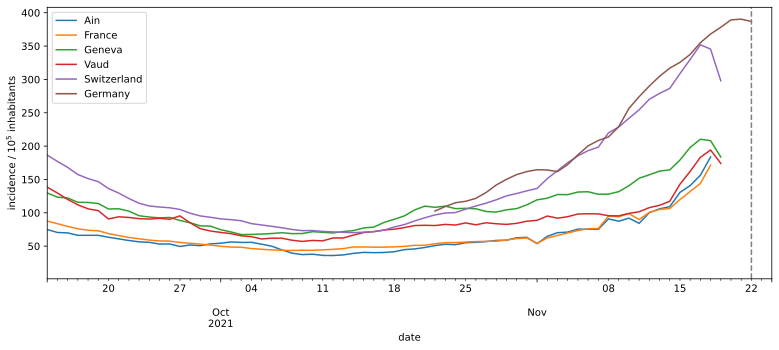

,Ain,France,Geneva,Vaud,Switzerland,Germany
2021-11-16,140.801120,131.928789,198.09,162.13,329.99,337.571600
2021-11-17,156.327298,143.969317,210.33,183.24,351.87,354.981949
2021-11-18,183.726435,171.484778,208.16,194.17,345.46,368.123947
2021-11-19,NaN,NaN,183.67,174.04,297.94,378.287605
2021-11-20,NaN,NaN,NaN,NaN,NaN,389.306859
2021-11-21,NaN,NaN,NaN,NaN,NaN,390.410349
2021-11-22,NaN,NaN,NaN,NaN,NaN,386.791817


In [13]:
fig, ax = plt.subplots(figsize=(13,5))
inc_df[inc_df.index > datetime.datetime.now() - datetime.timedelta(weeks=10)].plot(ax=ax)
# inc_df.tail(7*8).plot(ax=ax)
# ax.set_yscale("log")
ax.axvline(datetime.date.today(), ls="--", c="gray")
ax.set_ylim(bottom=1)
ax.set_xlim(right=datetime.date.today() + datetime.timedelta(days=2))
ax.set_xlabel("date")
ax.set_ylabel("incidence / $10^5$ inhabitants")
plt.show()
display(inc_df.tail(7))

In [14]:
idx = inc_df.notna()[::-1].idxmax()
tab_df = pd.DataFrame({"indicence": [inc_df.loc[i][c] for i, c in zip(idx, inc_df.columns)], 
                       "date": [humanize.naturaltime(dt) for dt in idx]}, index=inc_df.columns)
    
display(tab_df)

,indicence,date
Ain,183.726435,4 days ago
France,171.484778,4 days ago
Geneva,183.670000,3 days ago
Vaud,174.040000,3 days ago
Switzerland,297.940000,3 days ago
Germany,386.791817,11 hours ago


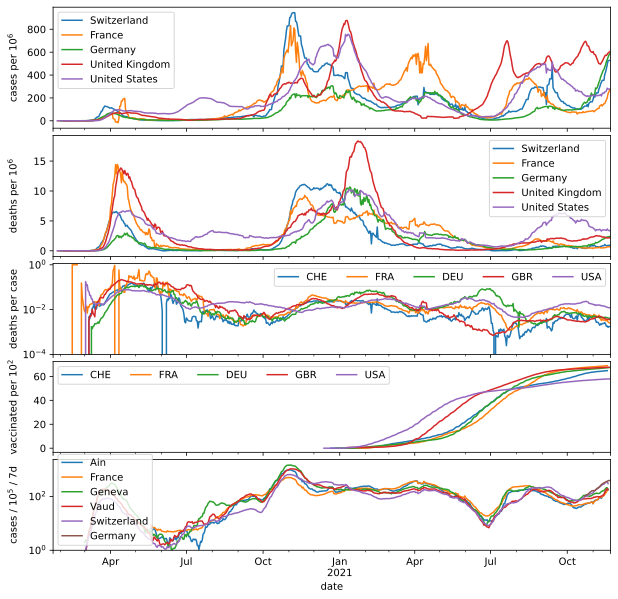

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 1, 0.75, 0.75, 0.75], "hspace": 0.07}, sharex=True)
ax1, ax2, ax3, ax4, ax5 = axs
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
):
    cdf = df[df.iso_code == country]
    
    name = cdf.location[0]
    cdf.plot(y="new_cases_smoothed_per_million", ax=ax1, label=name)
    cdf.plot(y="new_deaths_smoothed_per_million", ax=ax2, label=name)
   
    cdf.plot(y="death_ratio", ax=ax3, label=country)
    
    cdf.plot(y="people_fully_vaccinated_per_hundred", ax=ax4, label=f"{country}")
#     cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, ls="--", c=ax3.get_lines()[-1].get_color(), label=f"total")


# fr_dep_df[fr_dep_df.lib_dep == "Ain"].plot(y="tx_incid", ax=ax5, label="Ain")
# fr_df.plot(y="tx_incid", ax=ax5, label="France")
# ch_df[ch_df.geoRegion == "GE"].plot(y="inzsum7d", ax=ax5, label="Geneva")
# ch_df[ch_df.geoRegion == "VD"].plot(y="inzsum7d", ax=ax5, label="Vaud")
# ch_df[ch_df.geoRegion == "CH"].plot(y="inzsum7d", ax=ax5, label="Switzerland")
inc_df.plot(ax=ax5)
ax5.set_yscale("log")
ax5.set_ylim(bottom=1)

ax5.set_xlabel("date")
ax5.set_ylabel("cases / $10^5$ / 7d")

ax4.legend(ncol=5)
ax3.legend(ncol=5)

ax3.set_ylim(bottom=1e-4)
ax3.set_yscale("log")

ax1.set_ylabel("cases per $10^6$")
ax2.set_ylabel("deaths per $10^6$")
ax3.set_ylabel("deaths per case")
ax4.set_ylabel("vaccinated per $10^2$")

fig.align_ylabels()
# fig.tight_layout()
plt.show()

### Switzerland

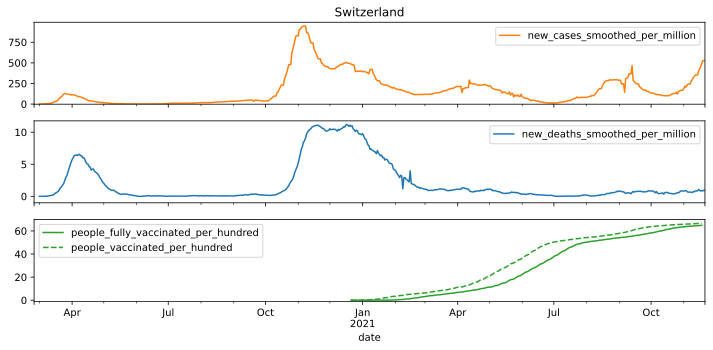

### France

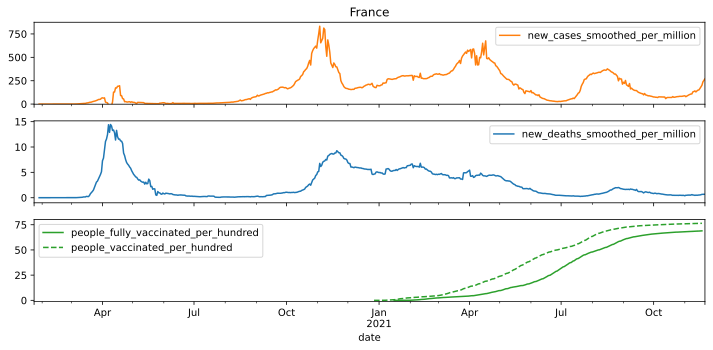

### Germany

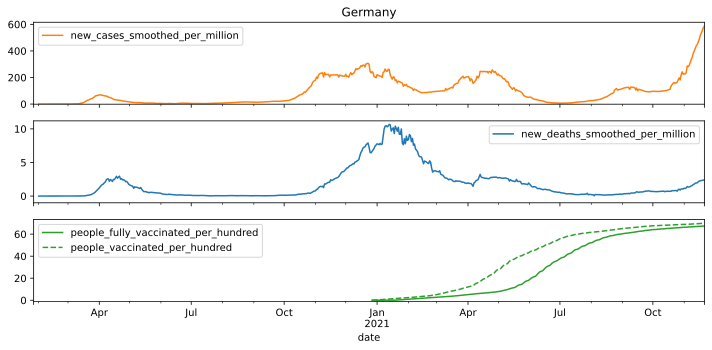

### United Kingdom

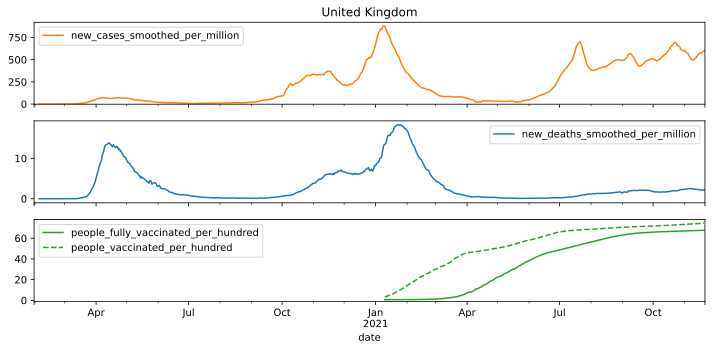

### United States

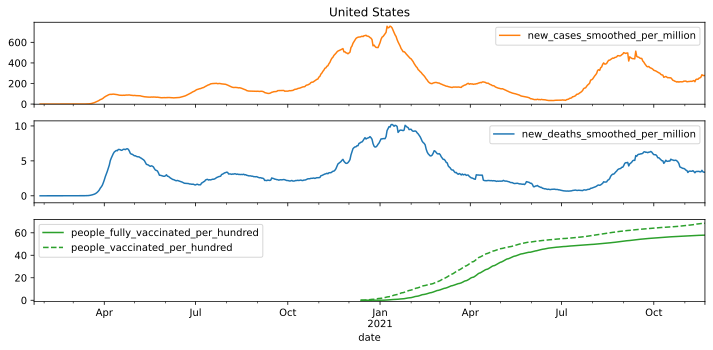

### Greece

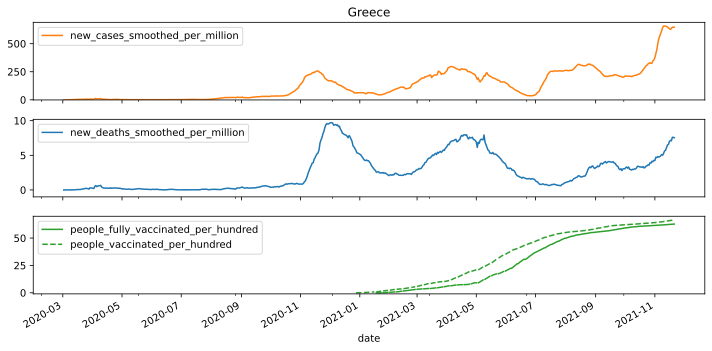

In [16]:
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
    "GRC"
):
    cdf = df[df.iso_code == country]
    display(Markdown(f"### {cdf.location[0]}"))
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
    ax1, ax2, ax3 = axs
    cdf.plot(y="new_cases_smoothed_per_million", ax=ax1, c="tab:orange")
    cdf.plot(y="new_deaths_smoothed_per_million", ax=ax2, c="tab:blue")
    cdf.plot(y="people_fully_vaccinated_per_hundred", ax=ax3, c="tab:green")
    cdf.plot(y="people_vaccinated_per_hundred", ax=ax3, c="tab:green", ls="--")
    
    for ax in axs:
        ax.set_ylim(bottom=-1)

    ax1.set_title(cdf.location[0])
    fig.tight_layout()
    plt.show()